In [1]:
import numpy as np
import torch
import sklearn
import tensorflow as tf

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

In [3]:
y = mnist.target
x = mnist.data
print(type(y))
print(x.shape)

<class 'numpy.ndarray'>
(70000, 784)


In [4]:
x = x.reshape((70000, 28, 28))

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 17)
x_train, x_val, y_train, y_val =  train_test_split(x_train, y_train, test_size=0.2, random_state=40)
print('%d train, %d validation, %d test data' % (len(x_train), len(x_val), len(x_test)))

39200 train, 9800 validation, 21000 test data


In [7]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):

        super(AutoEncoder, self).__init__()


        self.encoder = torch.nn.Sequential(                                         # B 1  28 28
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0),             # B 32 26 26
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),            # B 32 24 24
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                 # B 32 12 12

            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),            # B 64 10 10
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),            # B 64 8  8
            torch.nn.ReLU(),

            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),         # B 64 4  4

        )
            
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, padding=0),   # B 64 8  8      
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, padding=0),   # B 64 16 16
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0),   # B 32 32 32
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),            # B 32 30 30
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=0),             # B 1  28 28
            torch.nn.ELU()
        )


        self.loss_function = torch.nn.MSELoss()

        self.batch_placeholder = torch.zeros(size=[1, 1, 28, 28], dtype=torch.float32, device=torch.device('cuda:0'))

        self.decider = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(8 * 8 * 64, 128), # B 64
            torch.nn.ELU(),
            torch.nn.Linear(128, 10) # B 10
        )


    def forward(self, batch):
        encoded = self.encoder(batch)
        decoded = self.decoder(encoded)

        loss = self.loss_function(decoded, batch)

        return decoded, loss
    
        

In [8]:
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [9]:
model = AutoEncoder()
model = model.cuda()

In [10]:
for n, v in model.named_parameters():
  print(n)

encoder.0.weight
encoder.0.bias
encoder.2.weight
encoder.2.bias
encoder.5.weight
encoder.5.bias
encoder.7.weight
encoder.7.bias
decoder.0.weight
decoder.0.bias
decoder.2.weight
decoder.2.bias
decoder.4.weight
decoder.4.bias
decoder.6.weight
decoder.6.bias
decoder.8.weight
decoder.8.bias
decider.1.weight
decider.1.bias
decider.3.weight
decider.3.bias


In [11]:
batch_size = 64
batch_x_placeholder = torch.zeros(size= [batch_size, 1, 28, 28], dtype = torch.float32, device =torch.device('cuda:0'))
batch_y_placeholder = torch.zeros(size= [batch_size], dtype = torch.long, device = torch.device('cuda:0'))
epochs = 30
train_loss = np.zeros((epochs,))
val_loss = np.zeros((epochs,))
train_acc = np.zeros((epochs,))
val_acc = np.zeros((epochs,))


In [12]:
optimizer = torch.optim.Adam(filter(
    lambda p : p.requires_grad, model.parameters()),
    lr = 0.001
)

In [13]:
from time import time

In [14]:
iters_per_epoch = int(np.ceil(1.0 * len(x_train) / batch_size))

for e in range(epochs):
    t_start = time()

    model.train() # training phase

    # shuffling
    inds = np.arange(len(x_train))
    np.random.shuffle(inds)

    epoch_loss = 0
    true_positive = 0


    # iterating over the whole training set
    for iter in range(iters_per_epoch):

        batch_inds = inds[iter * batch_size: min(len(inds), (iter + 1) * batch_size)]

        # reshaping placeholders
        if len(batch_inds) != len(batch_x_placeholder):
            batch_x_placeholder.resize_([len(batch_inds), 1, 28, 28])

        batch_x_placeholder.copy_(torch.Tensor(x_train[batch_inds, np.newaxis, :, :]))

        _, b_loss = model(batch_x_placeholder)
      
        epoch_loss += float(b_loss) / iters_per_epoch  # CARE: WE SHOULD USE FLOAT OVER LOSS

        b_loss.backward() # calculates derivations

        optimizer.step()
        optimizer.zero_grad() # CARE: MUST DO

    train_loss[e] = epoch_loss
    
    
 # Validating over validation data
    with torch.no_grad():
        
        model.eval()  # validation phase

        val_inds = np.arange(len(x_val))

        val_iters_per_epoch = int(np.ceil(1.0 * len(x_val) / batch_size))

        epoch_validation_loss = 0

        reconstructeds = []
        loss = 0

        # iterating over the whole training set
        for iter in range(val_iters_per_epoch):

            val_batch_inds = val_inds[iter * batch_size: min(len(val_inds), (iter + 1) * batch_size)]

            # reshaping placeholders
            if len(val_batch_inds) != len(batch_x_placeholder):
                batch_x_placeholder.resize_([len(val_batch_inds), 1, 28, 28])

            batch_x_placeholder.copy_(torch.Tensor(x_val[val_batch_inds, np.newaxis, :, :]))

            b_decision, b_loss = model(batch_x_placeholder)
            b_decision = b_decision.cpu().numpy()
        
            epoch_validation_loss += float(b_loss) / val_iters_per_epoch  # CARE: WE SHOULD USE FLOAT OVER LOSS
            reconstructeds.append(b_decision)
        
        reconstructeds, test_loss = np.concatenate(reconstructeds), loss    
        val_loss[e] = epoch_validation_loss
        
        # TO Complete
    
    print(f'Train epoch Loss: {epoch_loss:.4f}, Validation Loss: {epoch_validation_loss:.4f}')

    # Saving the model and optimizer state
    torch.save({
            'epoch': e,
            'optimizer_state_dict': optimizer.state_dict(),
            'model_state_dict': model.state_dict(),
            'train_loss': epoch_loss,
            'validation_loss': epoch_validation_loss,
        }, 'epoch_%d_state.pt' % e)

    print('Epoch %d ended in %.2f secs.' % (e, time() - t_start,))



Train epoch Loss: 0.0561, Validation Loss: 0.0392
Epoch 0 ended in 4.80 secs.
Train epoch Loss: 0.0338, Validation Loss: 0.0290
Epoch 1 ended in 4.73 secs.
Train epoch Loss: 0.0264, Validation Loss: 0.0242
Epoch 2 ended in 4.74 secs.
Train epoch Loss: 0.0225, Validation Loss: 0.0211
Epoch 3 ended in 4.73 secs.
Train epoch Loss: 0.0200, Validation Loss: 0.0192
Epoch 4 ended in 4.73 secs.
Train epoch Loss: 0.0181, Validation Loss: 0.0178
Epoch 5 ended in 4.74 secs.
Train epoch Loss: 0.0168, Validation Loss: 0.0171
Epoch 6 ended in 4.74 secs.
Train epoch Loss: 0.0156, Validation Loss: 0.0157
Epoch 7 ended in 4.74 secs.
Train epoch Loss: 0.0148, Validation Loss: 0.0151
Epoch 8 ended in 4.74 secs.
Train epoch Loss: 0.0141, Validation Loss: 0.0139
Epoch 9 ended in 4.75 secs.
Train epoch Loss: 0.0133, Validation Loss: 0.0135
Epoch 10 ended in 4.75 secs.
Train epoch Loss: 0.0130, Validation Loss: 0.0134
Epoch 11 ended in 4.75 secs.
Train epoch Loss: 0.0125, Validation Loss: 0.0137
Epoch 12 end

In [15]:
import matplotlib.pyplot as plt

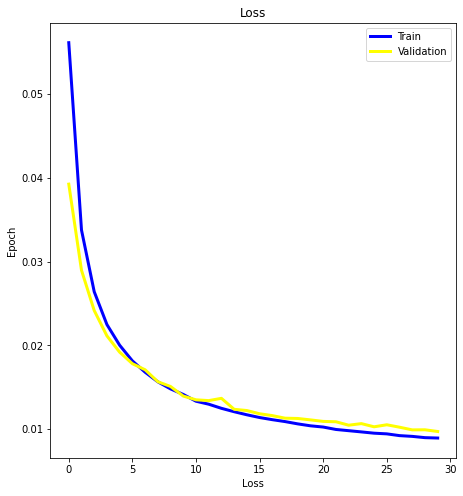

In [16]:
fig = plt.figure(figsize=(16, 8))


# loss
ax = fig.add_subplot(121)
ax.set_title('Loss')
ax.set_xlabel('Loss')
ax.set_ylabel('Epoch')
ax.set_aspect('auto')

plt.plot(train_loss, label='Train', color='blue', linewidth=3)
plt.plot(val_loss, label='Validation', color='yellow', linewidth=3)

plt.legend()

In [17]:


with torch.no_grad():
        model.eval()  # validation phase

        val_inds = np.arange(len(x_test))

        val_iters_per_epoch = int(np.ceil(1.0 * len(x_test) / batch_size))

        epoch_validation_loss = 0
        reconstructeds = []

        # iterating over the whole training set
        for iter in range(val_iters_per_epoch):

            val_batch_inds = val_inds[iter * batch_size: min(len(val_inds), (iter + 1) * batch_size)]

            # reshaping placeholders
            if len(val_batch_inds) != len(batch_x_placeholder):
                batch_x_placeholder.resize_([len(val_batch_inds), 1, 28, 28])

            batch_x_placeholder.copy_(torch.Tensor(x_test[val_batch_inds, np.newaxis, :, :]))

            b_decision, b_loss = model(batch_x_placeholder)
            b_decision = b_decision.cpu().numpy()


            reconstructeds.append(b_decision)
        
            epoch_validation_loss += float(b_loss) / val_iters_per_epoch  # CARE: WE SHOULD USE FLOAT OVER LOSS
                
        val_loss = epoch_validation_loss
        reconstructeds, test_loss = np.concatenate(reconstructeds), loss    



print('Test Loss %.4f ' % (val_loss))

Test Loss 0.0096 


[ 6696  4938 15118 12231 18424  2951  1708   615   257  2295 16799  4988
  1952   481 13493  1758  8508 10426   844  5471  4307  5544  2183 12679
 19926 15937  7031 14147  2014  1396 11356  2527 11104 11730 11074 14614
 17166  1900  9485  2283]
(21000, 1, 28, 28)


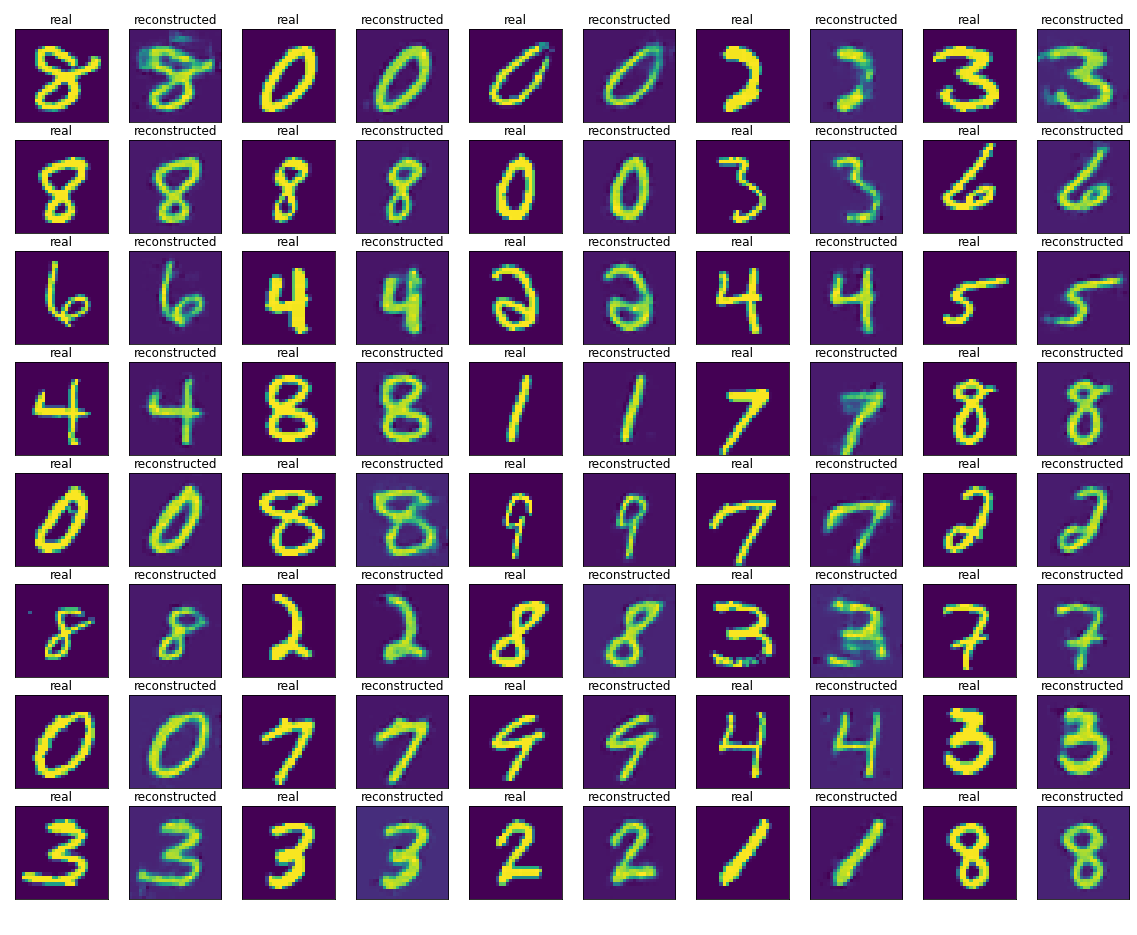

In [18]:
rows = 8
columns = 10
indices = np.random.choice(np.arange(len(x_test)), size=rows * columns // 2)
images = np.zeros((rows * columns // 2, 2, 28, 28))
images[:,0] = x_test[indices].reshape(rows * columns // 2, 28, 28)
print(indices)
print(reconstructeds.shape)
images[:,1] = reconstructeds[indices].reshape(rows * columns // 2, 28, 28)
images = images.reshape(rows * columns, 28, 28) * 255

texts = np.zeros((rows * columns // 2, 2), dtype=object)
texts[:,0] = np.array(['real' for _ in range(rows * columns // 2)])
texts[:,1] = np.array(['reconstructed' for _ in range(rows * columns // 2)])
texts = texts.reshape(rows * columns)

fig = plt.figure(figsize=(2 * columns, 2 * rows))

for i in range(columns * rows):
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.set_title(texts[i])
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(images[i].reshape((28, 28)))

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.set_frame_on(False)
plt.show()

In [19]:
with torch.no_grad():
        
    model.eval()  # validation phase

    inds = np.arange(len(x_test))

    iters_per_epoch = int(np.ceil(1.0 * len(x_test) / batch_size))

    epoch_loss = 0

    features = []
    reconstructeds = []
    loss = 0

    # iterating over the whole training set
    for iter in range(iters_per_epoch):

        batch_inds = inds[iter * batch_size: min(len(inds), (iter + 1) * batch_size)]

        # reshaping placeholders
        if len(batch_inds) != len(batch_x_placeholder):
            batch_x_placeholder.resize_([len(batch_inds), 1, 28, 28])

        batch_x_placeholder.copy_(torch.Tensor(x_test[batch_inds, np.newaxis, :, :]))

        b_decision, b_loss = model(batch_x_placeholder)
        b_decision = b_decision.flatten(1).cpu().numpy()
    
        epoch_loss += float(b_loss) / iters_per_epoch  # CARE: WE SHOULD USE FLOAT OVER LOSS
        reconstructeds.append(b_decision)
    
    features = np.concatenate(reconstructeds)    


In [20]:
centers = np.zeros((10, features.shape[1]))
y_test = y_test.astype(int)
features.shape

(21000, 784)

In [21]:
for label in range(10):
    centers[label] = features[y_test == label].mean(axis=0)

In [22]:
from sklearn.cluster import MiniBatchKMeans

clustering = MiniBatchKMeans(n_clusters=10, batch_size=batch_size, verbose=2, init=centers, n_init=1)

In [29]:
clustering.fit(features)

Init 1/1 with method: [[-3.0678962e-04 -3.0490980e-04 -3.0303962e-04 ... -3.0424673e-04
  -3.0454661e-04 -3.0179045e-04]
 [-3.0696392e-04 -3.0696392e-04 -3.0696392e-04 ... -2.8288702e-04
  -2.7978333e-04 -2.9558956e-04]
 [-2.9401595e-04 -2.7911155e-04 -2.2744774e-04 ...  8.6294813e-04
   5.9499275e-06 -3.2896295e-04]
 ...
 [-2.0222309e-04 -2.4484808e-04 -2.6330783e-04 ...  3.6142333e-04
  -2.3984064e-04 -2.1554429e-04]
 [-3.0696375e-04 -3.0796966e-04 -3.0184470e-04 ... -2.8118768e-04
  -3.0583117e-04 -3.3314427e-04]
 [-3.0696392e-04 -3.0696392e-04 -3.0696392e-04 ...  2.1692044e-04
  -2.4119845e-04 -2.9499471e-04]]
Inertia for init 1/1: 6016.875977
Minibatch iteration 1/32900: mean batch inertia: 33.066586, ewa inertia: 33.066586 
Minibatch iteration 2/32900: mean batch inertia: 31.775307, ewa inertia: 33.058715 
Minibatch iteration 3/32900: mean batch inertia: 33.828465, ewa inertia: 33.063407 
Minibatch iteration 4/32900: mean batch inertia: 34.166275, ewa inertia: 33.070129 
Minibatc

MiniBatchKMeans(batch_size=64, compute_labels=True,
                init=array([[-3.0678962e-04, -3.0490980e-04, -3.0303962e-04, ...,
        -3.0424673e-04, -3.0454661e-04, -3.0179045e-04],
       [-3.0696392e-04, -3.0696392e-04, -3.0696392e-04, ...,
        -2.8288702e-04, -2.7978333e-04, -2.9558956e-04],
       [-2.9401595e-04, -2.7911155e-04, -2.2744774e-04, ...,
         8.6294813e-04,  5.9499275e-06, -3.2896295e-04],
       .....
         3.6142333e-04, -2.3984064e-04, -2.1554429e-04],
       [-3.0696375e-04, -3.0796966e-04, -3.0184470e-04, ...,
        -2.8118768e-04, -3.0583117e-04, -3.3314427e-04],
       [-3.0696392e-04, -3.0696392e-04, -3.0696392e-04, ...,
         2.1692044e-04, -2.4119845e-04, -2.9499471e-04]], dtype=float32),
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=1, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=2)

In [24]:
matching_matrix = np.zeros((10, 10))

In [25]:
clusters = clustering.predict(features)

Computing label assignment and total inertia


In [26]:
for cluster in range(10):
    for label in range(10):
        matching_matrix[cluster, label] = (y_test[clusters == cluster] == label).sum()

Text(0, 0.5, 'Cluster')

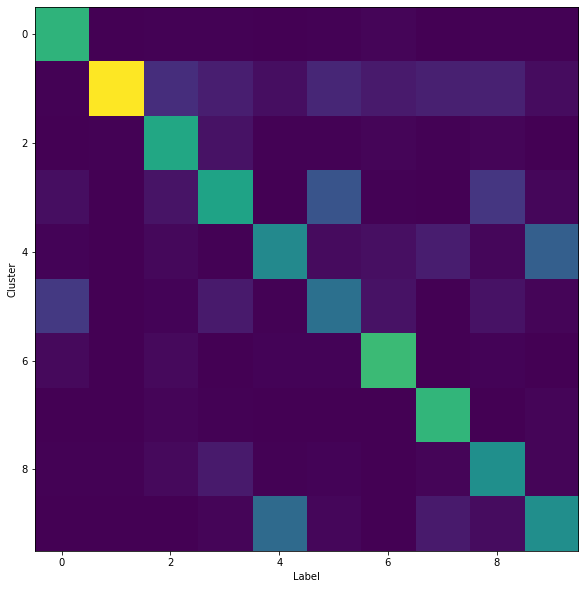

In [27]:
plt.figure(figsize=(10, 10))
plt.imshow(matching_matrix.astype(int))
plt.xlabel('Label')
plt.ylabel('Cluster')

In [28]:
print('accuracy:', np.diagonal(matching_matrix).sum() / matching_matrix.sum())

accuracy: 0.6685714285714286
